<a href="https://colab.research.google.com/github/CodingPenguins/ML3/blob/main/Copy_of_Week5_KaggleProjectGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "I’m Something of a Painter Myself" - Kaggle GAN challenge



## Introduction

This Kaggle challenge (accessible here: https://www.kaggle.com/competitions/gan-getting-started/) is about GAN creation on the basis of images painted by Claude Monet (https://en.wikipedia.org/wiki/Claude_Monet).
The data set contains 300 images of Monet's works with a resolution of 256x256(x3), either provided as JPEG or TFRecord (this notebook will use the former).
Additionally, 7028 photos unrelated to Monet's paintings are provided in the same formats, which can be used as a basis for image generation of the to be trained generator so to create Monet-like images (although the images can also be created from scratch, see: https://www.kaggle.com/competitions/gan-getting-started/data, which we will use here).

The aim is to create a GAN so to output 7k to 10k images (provided as a zip), which will be assessed (at least on Kaggle) within a Kaggle notebook, wherein scoring is based on (MiFID (Memorization-informed Fréchet Inception Distance) - the lower, the better).

## Data preprocessing

In [ ]:
import keras
import tensorflow as tf

from keras import layers
from keras import ops
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from PIL import Image


First, before using all our limited runs on Kaggle, we will be training the GAN in our Jupyter Notebook. For this, we will start with the example given in the course, that is the following keras example: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [ ]:
path = "/content/drive/MyDrive/ColabNotebooks/ML3-Week5/monetjpg/"

As we have not only images of 256x256 size, but also of RGB colour values (which range up to the value of 255), we have to squash them to a reasonable range. Conventions most commonly used are either the range of [-1:1] or [0:1], and since non-negative values for colours are more intuitive, we will use the latter:

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    path, label_mode=None, image_size=(256, 256), batch_size=4
)
dataset = dataset.map(lambda x: x / 255.0)


Found 300 files.


Let us take a look at a random image from the monet dataset:

In [ ]:
sample_nr = 1
sample_nr2 = 1

In [ ]:
i = 0
for item in dataset:
  print(i)
  if i == sample_nr:
    sampled_image = item[sample_nr2]
    break
  else:
    i += 1

0
1


In [ ]:
sampled_image.shape

TensorShape([256, 256, 3])

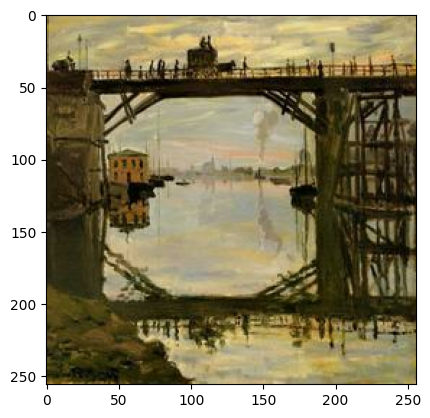

In [ ]:
plt.imshow((sampled_image.numpy() * 255).astype("int32"))

Looks like a Monet painting to me.

## A first GAN based on the keras example

### Defining a discriminator

We will continue with the discriminator given by the keras example (just adapted to our image sizes: that is modifying the shape, adapting the input layyers of our fist convolutional layer to correspond to this, and increasing the downstream layer to 2 times the size of the first layer), and see if we can improve it afterwards:

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 128, 128, 256)       │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_66 (LeakyReLU)           │ (None, 128, 128, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 64, 64, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_67 (LeakyReLU)           │ (None, 64, 64, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 32, 32, 512)         │       4,194,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_68 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 524288)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │         524,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,829,313 (26.05 MB)

 Trainable params: 6,829,313 (26.05 MB)

 Non-trainable params: 0 (0.00 B)

### Defining a generator

As for the discriminator, we start with the example code. As it needs to mirror our discriminator, all conv2d layers are translated into conv2dtranspose layers, but not necessary of corresponding size

In [ ]:
latent_dim = 512

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 512),
        layers.Reshape((32, 32, 512)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                     │ (None, 524288)              │     268,959,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_14 (Reshape)                 │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_42                  │ (None, 64, 64, 128)         │       1,048,704 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_69 (LeakyReLU)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_43                  │ (None, 128, 128, 128)       │         262,272 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_70 (LeakyReLU)           │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_44                  │ (None, 256, 256, 256)       │         524,544 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_71 (LeakyReLU)           │ (None, 256, 256, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 256, 256, 3)         │          19,203 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,814,467 (1.01 GB)

 Trainable params: 270,814,467 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

### Define the GAN

We generate the GAN model as outlined in the example:

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


We also copy the callback for creating images throughout the generation procedure

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=512):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.jpg" % (epoch, i))


### Train the GAN

In [ ]:
epochs = 500  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


For illustration, let us look at some of the images generated in the latest epochs:

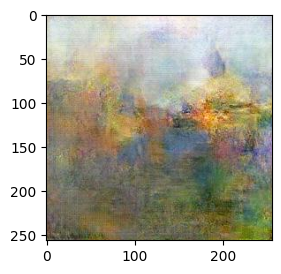

In [ ]:
sample_gen_img = "generated_img_%03d_%d.jpg" % (499, 9)
#sample_gen_img2 = "generated_img_800_11.jpg"
img = np.asarray(Image.open(sample_gen_img))

imgplot = plt.imshow(img)

In [ ]:
last_gen_img = []
for i in range(0,10):
    sample_gen_img = ("generated_img_%03d_%d.jpg" % (epochs-1, i))
    last_gen_img.append(np.asarray(Image.open(sample_gen_img)))

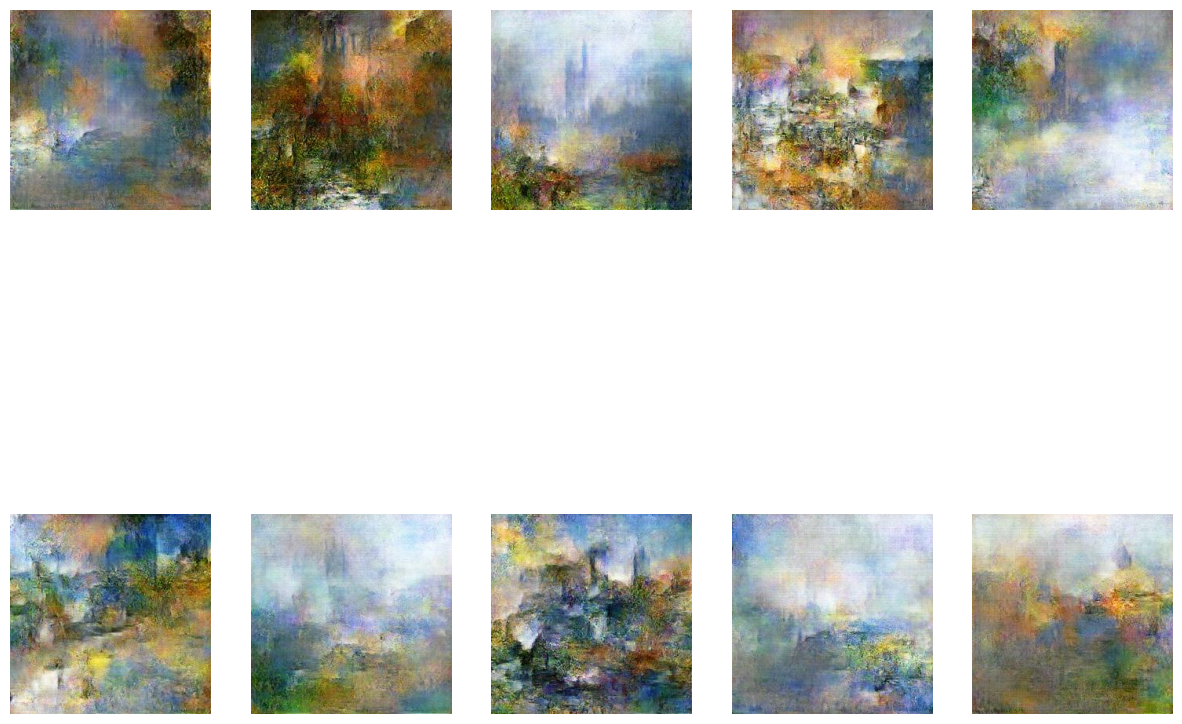

In [ ]:
plt.figure(figsize=(15, 12))
for j in range(0,10):

  plt.subplot(2,5,j+1)
  imgplot = plt.imshow(last_gen_img[j])
  plt.axis("off")

Well, we do see that images follow a general trend of following up on the misty landscapes Monet created - while some actually look quite decent, it is still a long way before a human could be fooled by most of them. But what about a machine? Let's take a look at how we score in the Kaggle competition.

## Scoring on Kaggle for the base model

To submit the above as a Kaggle notebook, minor modifications were introduced to work within different paths or generate the zip file. For the sake of brevity, only the latter part of the code is copied commented out below (with the rest being visible from the linked Kaggle notebook: https://www.kaggle.com/code/codingpenguins/notebookc688335327/notebook)

In [ ]:
#num_img = 20 ## Set the number of images generated in one go to 20
#loops = ceil(7000/num_img) ##To submit 7000 images, this is repeated batchwise for 7000/20 times

#for j in range(0,loops): ##Iterating for 20 images per batch

#  random_latent_vectors = keras.random.normal( ##generating the random_latent_vectors as for the GANmonitor function, so to create random starting points for image generation
#              shape=(num_img, latent_dim)
#          )
#  generated_images = gan.generator(random_latent_vectors) ##Running the generator on each of the random latent vectors
#  generated_images *= 255 ##Rescale to RGB values
#  generated_images.numpy() ##Convert to numpy array
#  for i in range(num_img): ##Iterate for each image in the batch to: a) generate an actual image from the array and b) save the image as a jpg
#      img = keras.utils.array_to_img(generated_images[i])
#      img.save("/kaggle/temp/generated_img_%04d_%d.jpg" % (j, i))

#shutil.make_archive("/kaggle/working/images", "zip", "/kaggle/temp/") ##Save all images in the folder as a zip, as required by the competition



After submitting the generated image, the following scoring was given - not bad for a non-tuned first try using 500 epochs (as defined in the competition, the smaller the MiFID score, the better the model). Right now, the rolling leaderboard has a current high score of 33.88, with a total of 220 ranked submissions).

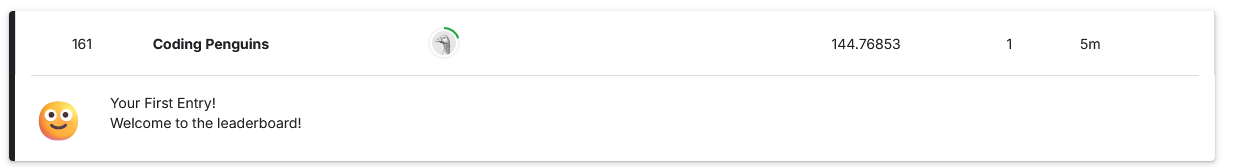

Kaggle used close to 3 hours to run the code (2h 53m, out of a maximum of 5 GPU hours available).

## The good, the bad and the ugly - visual evaluation of the output images

So, for the competition, we use the Memorization-informed Fréchet Inception Distance as an evaluation metric, which we do not even calculate ourselves, as it requires the remaining (hidden) set of Monet paintings used in the competition. So what could we do instead? We could in theory hold back a subset of the 300 images to replicate the same metric on said subset - but that might be misleading, as the number of images is low to begin with. If we only hold back 10% of the data, evaluation would be based on 30 (!) images.
Since we already have the evaluation metric embedded in the kaggle competition, let us (unlike all the previous Kaggle competitions and rather unscientifically) take a look at representatives within the data visually.

What we want to see is the following: Are there images actually appearing to carry a semblance to Monet's paintings? Do we have images that look like obvious counterfeits, horror-movie reinterpretations easily identified? And do we have images that easily identify as noise?

So, as a first representative of the ugly, we have an image that carries smaller fragments of an image within a soup of mashed paint - clearly nothing we want to see when generating Monet paintings. So we have outputs where our GAN clearly still fails.

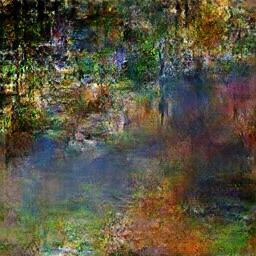

Next, we have a represenative of bad reinterpretations. The GAN clearly generates the foggy impression found in many Monet images, with a structure (tower?) being barely visible behind that foggy curtain. In front, we have a represenation of a landscape, mixing forests and bodies of water. However, fog is applied unequally, creating partially blurred, and partially sharp (see trees in the lower left corner) represenations stitched together, with seams clearly visible.

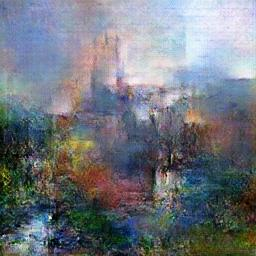

The trained GAN also outputs more consistent landscapes hidden behind layers of fog, with a building' silhouette standing out partially from said backgrounds. No inconsistencies or sharp edges are immediately visible. What we do not have are representatives of Monet's paintings not having said foggy veil applied to them - and most of the crips images are at best clearly identifiable as counterfeits.
Of the 7000 images, most fall within category 2, at least from a superficial first glance analysis.
We therefore still have a lot of work to do before fooling a human being.

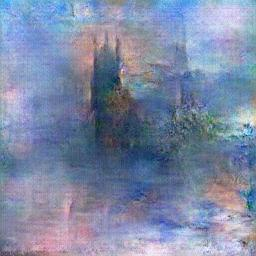

## Improving on the model - Increasing the number of epochs from 500 to 750

As a general remark, since getting the models to run fast enough outside of Kaggle is resource intensive and requires access to suitable GPUs, I refrain from re-running the models in this notebook. The changes are pasted below as code, but are not executed (and therefore no direct output is provided below, though some images are re-imported from the generated zip file on Kaggle for illustration).

To improve on the model, we have a plurality of options. The most straightforward would be to get a feeling on whether increasing on the number of epochs will yield us more Monet-like images.

So let's start by increasing the number of epochs by factor 1.5 (remember, we have used almost 3 hours of run-time, whereas the competition requires us to run within 5 hours when using GPUs!). If we do not see an immediate improvement, we might also consider reducing the number of trainable parameters and increasing the epochs further (so to stay within the 5 hour time frame).

The code for this looks like this with the GANMonitor not being used for Kaggle outputs:

In [ ]:
epochs = 750  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs #, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


## Kaggle score for 750 epochs

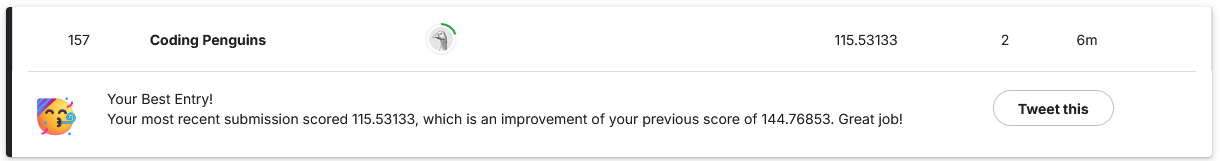

Well, at first glance, improving by a ratio of

In [ ]:
print(144.76853/115.53133)

1.2530672848654993


appears to be decent, but within the competition's restrictive environment of 5 hours run-time, we have to take the latter into account as well. The script ran for 4h 17m.

In [ ]:
print((4*60+17)/(2*60 +53))

1.4855491329479769


As to be expected, increasing the number of epochs by 50% has a proportional impact on the runtime, while our models score "merely" improved by 25% (whether that is good or bad depends on the MiFID scoring system, with the hidden Monet paintings contributing to said scoring - as such, let's not delve further into that topic, but merely take the improvement as a reference, to see whether we can build a model that performs better within a similar time-constrained run-time of less than 5 hours. The most important aspect to keep in mind is that we certainly do not expect any linearity between run-time and scoring, and we should not apply intuition in view of the factors not being readily accessible for interpretation).

For a more intuitive interpretation of the improvement, the increase in score merely took us from high score position #161 to #157 - so there is room for improvement!

## The good, the bad and the ugly - Model 2

When scrolling through the thumb-nails of all 7000 images, it appears that the painings unrecognizable to be related to a Monet style are reduced in number. Apart from that, the GAN has generated quite some interesting pieces of art, such as the following:

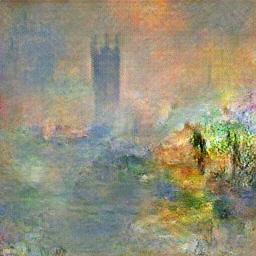

Most of the images are still not consistent in style and bad replicas of Monet's work, such as this one, which is mixing foggy imagery with more abstract paintings:

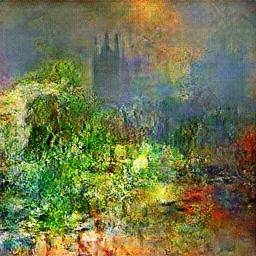

The bad images are usually a patch-work of a bit more recognizable fragments.

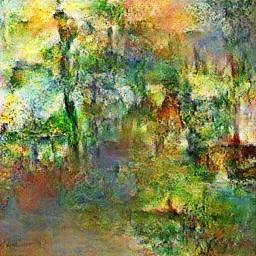

## Model 3

So, where does this leave us? How can we get closer to the upper positions of the leaderboard?

One option would be to (somewhat counter-intuitive) reduce the number of trainable parameters: Since we are facing a time-constraint, it might be that a less complex model can be better trained within 5 hours. Another option would be to look at the optimizer functions (currently Adam) and the associated learning rates (1E-4 for both in the models above). We could also consider using another loss function instead of Binary Cross Entropy.

Adam usually is a computationally efficient optimizer suitable for image tasks (https://keras.io/api/optimizers/adam/). However, AdamW (which introduces the concept of weight decays into Adam: https://keras.io/api/optimizers/adamw/) might help with the generalization performance (https://arxiv.org/abs/1711.05101). So we go down to 500 Epochs again and run the model with the default weight_decay of 4E-3.

In [ ]:
epochs = 500  #

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004),
    g_optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


## Submission to Kaggle

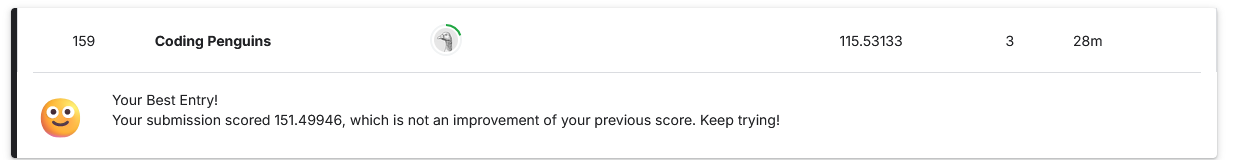

The Notebook ran in 2h 51m, and thereby only 2 minutes faster than the first model, while being slightly outperformed by it (144.7 vs 151.5).

No image analysis is provided at this point, as the images are comparable to the first model generated.

## Model 4: Improving on the learning rate

The next attempt is to default to the original model, and increase the learning rate by a factor of 10. Varying the learning rate could also help with 'Mode Collapse', which we have observed so far (the GAN primarily outputs images of landscapes behind fog, while scarcely outputting outer Monet style paintings).

Depending on how this impacts the model training process in terms of time spent, we might then ramp up the number of epochs proportionally. The code submitted to Kaggle is as follows:

In [ ]:
epochs = 500  #

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs #, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


### Kaggle results (LR = 0.001)

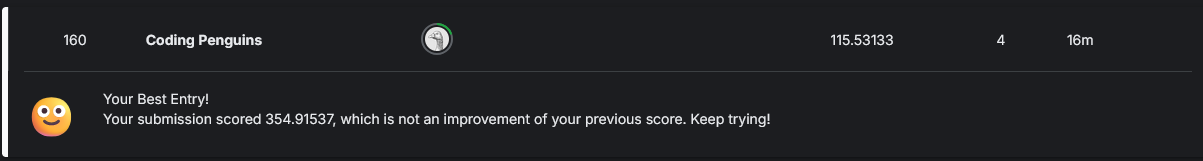

With a runtime of 2h 50m, reducing the LR did not yield any benefit. In fact, it produced only empty canvasses (see "painting" below).

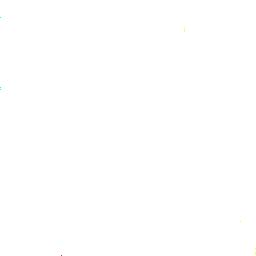

How about reducing the LR further? Let's start with a factor of 0.5 compared to the base model, and see what happens.

### Reducing the LR (LR = 0.00005)

In [ ]:
epochs = 500 #an even higher number #500  # Quite a high number

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    #dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    dataset, epochs=epochs
)


### Kaggle results  (LR = 0.00005)

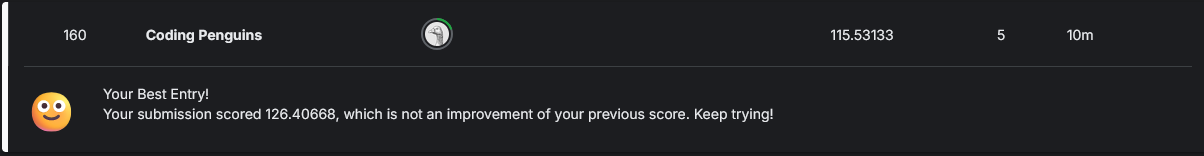

Within a runtime of 2h 52m, we have improved our score from 144.77 (base model) to 115.53 by halving the LR - at no cost to the actual run time. Before taking a deeper look at the images generated, let's see whether dropping the LR down to 1E-5 would benefit the model even further, before ramping up the epochs to 750 again.

### Further reducing the LR (LR = 0.00001)

We use the following code:

In [ ]:
epochs = 500 #an even higher number #500  # Quite a high number

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    #dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    dataset, epochs=epochs
)


### Kaggle results (LR = 0.00001)

With a runtime of 2h 52m, we now see a worsening of the score again:

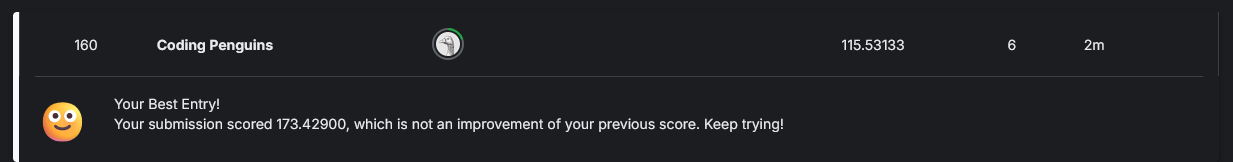

### Model 6 : LR up to 0.00005, Epochs to 750

Since we had our best result with a LR of 0.00005, we move up again to 750 epochs and see how good our model is performing:

In [ ]:
epochs = 750 #an even higher number #500  # Quite a high number

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    #dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
    dataset, epochs=epochs
)


### Kaggle submission

4h 22m was the total runtime of the Kaggle script. With 750 epochs, we received the following score:

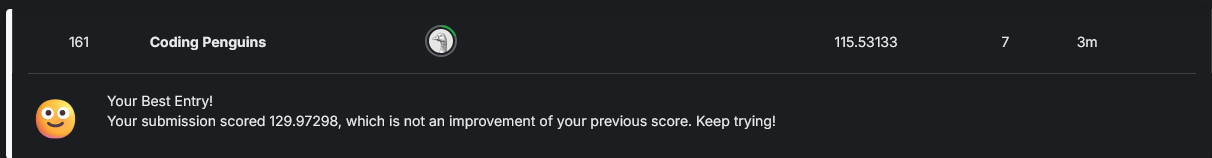

Somewhat unexpected, we do not improve on our best score of 115.5 with 750 epochs. From this, it appears that the main limitations of the model created are not the choice of LRs, but rather other factors in model creation.

## Comparison with other models

In view of using a GAN requiring a lot of resources to train and the competition requiring us to submit the code to Kaggle for evaluation on the Metric, it makes little sense to come up with reference models to compare the above attempts with. Rather, I'll discuss further options on modifying the models below, which will not be submitted to Kaggle any further (in particular as the 30h of run time have been exhausted).

As part of the discussion, I'll later look at the better performing models in the Kaggle leaderboard, which have decided to use another GAN (and not a DCGAN as chosen for the models herein).

## Summary, Potential future improvements, Comparison with high-scoring models

### What went well:

We have sucessfully created a GAN that can generate images in the style of Monet, albeit limited and biased towards foggy landscapes. With the best scoring model achieving 115.5 MiFID and the illustrated paintings as above, we have established a foundational model which needs further resource and time investment to be fine-tuned.
We have also seen that the model's performance is somewhat effected by the LR (although we have initially chosen a good LR), and less effected by the optimizer (AdamW did not improve the results compared to Adam).

### What went not so well:

However, our score is far from perfect (or even being good), with the current highest scoring model achieving 33.9 in MiFID!
It is also questionable whether using a DCGAN was the best starting point for entering a competitition which has a hard limit on the GPU run-time, as other GANs might be computationally more efficient.

### Future endeavours

If I were to spend time on this project in the future, I would first try to further tune the model (as suggested in detail below) and try adding different layers, such as Conv-Conv-Pooling instead of the Conv2D layer used in both models.
Another option would be to challenge the assumption that generating images from scratch generates the same results as generating filters for existing images, and constructing our model to take the images provided in the challenge as starting points instead.
Finally, one could

### Potential Model 7 - Redefining Generator and Discriminator

One attempt would be to add additional layers to the discriminator and generator, e. g. changing the Conv2D layers to Conv-Conv-Pooling layers, as outlined below.

In [ ]:
discriminator2 = keras.Sequential(
    [
        keras.Input(shape=(256, 256, 3)),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.Conv2D(512, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator2",
)
discriminator2.summary()


In [ ]:
latent_dim = 512

generator2 = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 512),
        layers.Reshape((32, 32, 512)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.MaxPooling2D(padding="same"),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator2",
)
generator2.summary()


In [ ]:
epochs = 500  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator2, generator=generator2, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


### Comparison with well-performing models on Kaggle

When looking at the well-performing models on Kaggle (without pointing to specifc submissions), one can distinguish between individual implementations of rather specific algorithms adapted from publications, and (fine-)tuned versions of CycleGANs as given by the tutorial for the Kaggle competition (https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial), using the stock photos to apply a Monet filter. It appears that even with that stock approach, one can easily achieve MiFID scores of less than 40 - hinting that either DCGAN or image generation from scratch might be the bottleneck.